# Korelasi Fitur

Code untuk membuat figure penentuan fitur, dimana korelasi antara tiap fitur dihitung terhadap label. Hal ini dilakukan untuk mencari fitur dengan korelasi tertinggi sebagai fitur pada projek.


Fitur yang di uji:

- RMS: Root Mean Square
- ZCR: Zero Crossing Rate
- Spectral Centroid: Titik Pusat Spektrum (tidak disingkat, tapi nama lengkapnya sudah demikian)
- Log-mel Spectrogram: Logarithmic Mel-Frequency Spectrogram
- MFCC: Mel-Frequency Cepstral Coefficients


# Load


In [27]:
import math
import joblib
import numpy as np
from scipy import signal, fftpack
import librosa
import soundfile as sf
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from scipy.signal import resample_poly
import os
import pandas as pd
import json
import pickle
from typing import Tuple, List
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

In [28]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)
MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# MAIN_PATH = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

In [29]:
with open(MAIN_PATH + r"\Dataset\dataset_raw.pkl", "rb") as f:
    dataset = pickle.load(f)

# Functions


Pra-Pemrosesan


In [30]:
def load_file_audio(path: str) -> Tuple[np.ndarray, int]:
    audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=False)
    return audio, sr

def prapemrosesan_downmixing(audio: np.ndarray) -> np.ndarray:
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio: np.ndarray, sr: int) -> Tuple[np.ndarray, int]:
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    return audio_resampled, SAMPLE_RATE

def prapemrosesan_padding(audio: np.ndarray) -> np.ndarray:
    if len(audio) % SEGMENT_DURATION != 0:
        padding = SEGMENT_DURATION - (len(audio) % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio

def prapemrosesan_splitting(audio: np.ndarray) -> np.ndarray:
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = np.lib.stride_tricks.as_strided(
        audio,
        shape=(num_segments, SEGMENT_DURATION),
        strides=(OVERLAP_DURATION * audio.strides[0], audio.strides[0]),
        writeable=False
    )
    if len(segments[-1]) < SEGMENT_DURATION:
        segments[-1] = np.pad(segments[-1], (0, SEGMENT_DURATION - len(segments[-1])), 'constant')
    return segments

In [31]:
def prapemrosesan(path : str) -> np.ndarray:
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)

    return segments

Ekstraksi Fitur


In [32]:
def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_zcr(segment):
    return np.mean(librosa.feature.zero_crossing_rate(y=segment))

def get_sc(segment):
    return np.mean(librosa.feature.spectral_centroid(y=segment))

def get_lms(segment):
    return librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)

def get_mfcc(segment):
    return librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)

# Ekstraksi Fitur


In [33]:
dataset

[{'Path': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  'Timestamp': [0.0, 1.0],
  'Label': 2,
  'Segment': array([-6.6490856e-13, -2.0503420e-13,  1.9726230e-12, ...,
          1.7010156e-02,  1.5655354e-02,  1.3218733e-02], dtype=float32)},
 {'Path': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  'Timestamp': [0.5, 1.5],
  'Label': 2,
  'Segment': array([ 0.00699983, -0.00232209, -0.00932763, ..., -0.04057191,
         -0.06078785, -0.05000736], dtype=float32)},
 {'Path': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-canto\\19655.mp3',
  'Timestamp': [1.0, 2.0],
  'Label': 2,
  'Segment': array([ 0.00747406, -0.00234747, -0.01535155, ...,  0.01900513,
          0.05901422,  0.04412188], dtype=float32)},
 {'Path': 'C:\\Users\\Lulay\\Documents\\GitHub\\Dasar-Kecerdasan-Artificial_Tugas-Besar\\Dataset\\xeno-

In [34]:
dataset_fe = []

for data in dataset:
    segment = data["Segment"]

    features = {
        "Path": data["Path"],
        "Timestamp": data["Timestamp"],
        "Label": 1 if data["Label"] == 0 else data["Label"],
        "rms": np.mean(librosa.feature.rms(y=segment)),
        "zcr": np.mean(librosa.feature.zero_crossing_rate(y=segment)),
        "sc": np.mean(librosa.feature.spectral_centroid(y=segment)),
        "rolloff": np.mean(librosa.feature.spectral_rolloff(y=segment)),
        "bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=segment)),
        "mfcc_mean": np.mean(librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)),
        "mfcc_std": np.std(librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)),
        "lms_mean": np.mean(librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)),
        "lms_std": np.std(librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)),
        "contrast_mean": np.mean(librosa.feature.spectral_contrast(y=segment, sr=SAMPLE_RATE)),
        "contrast_std": np.std(librosa.feature.spectral_contrast(y=segment, sr=SAMPLE_RATE)),
        "tonnetz_mean": np.mean(librosa.feature.tonnetz(y=segment, sr=SAMPLE_RATE)),
        "tonnetz_std": np.std(librosa.feature.tonnetz(y=segment, sr=SAMPLE_RATE)),
        "chroma_mean": np.mean(librosa.feature.chroma_stft(y=segment, sr=SAMPLE_RATE)),
        "chroma_std": np.std(librosa.feature.chroma_stft(y=segment, sr=SAMPLE_RATE))
    }

    dataset_fe.append(features)

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [55]:
dataset_normalized = []

for data in dataset_fe:
    dataset_normalized.append({
        "Label": data["Label"],
        "rms": data["rms"],
        "zcr": data["zcr"],
        "sc": data["sc"],
        "mfcc_mean": data["mfcc_mean"],
        "mfcc_std": data["mfcc_std"],
        "lms_mean": data["lms_mean"],
        "lms_std": data["lms_std"],
    })

# Visualize


In [56]:
df = pd.DataFrame(dataset_normalized)

features = df.drop(columns=["Label"])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)

df_scaled["Label"] = df["Label"]

correlation_matrix = df_scaled.corr()

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


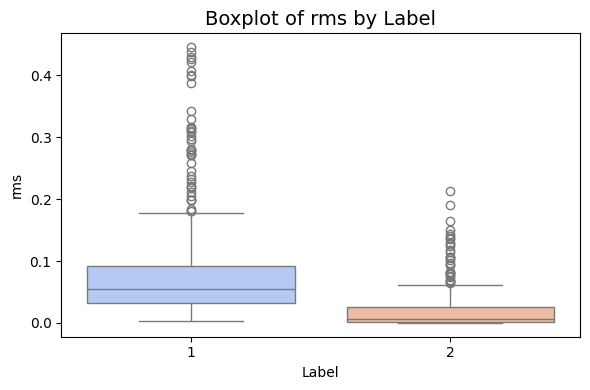

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


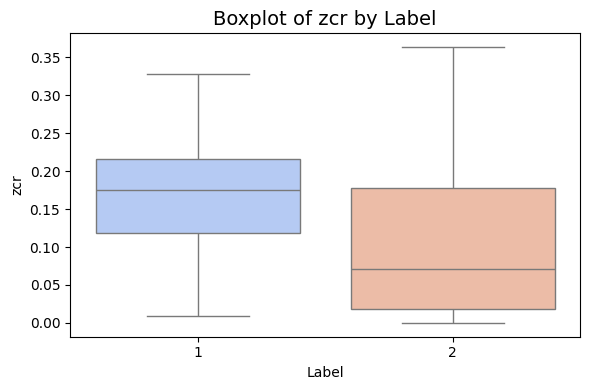

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


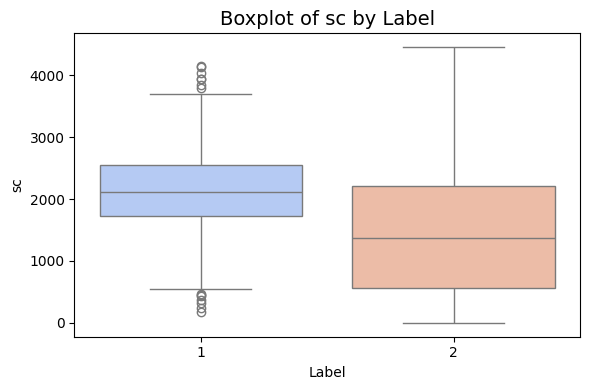

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


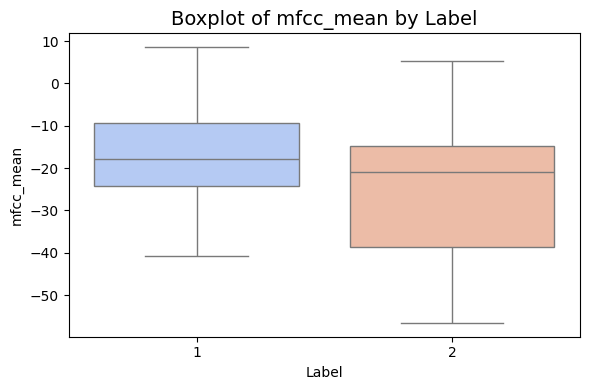

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


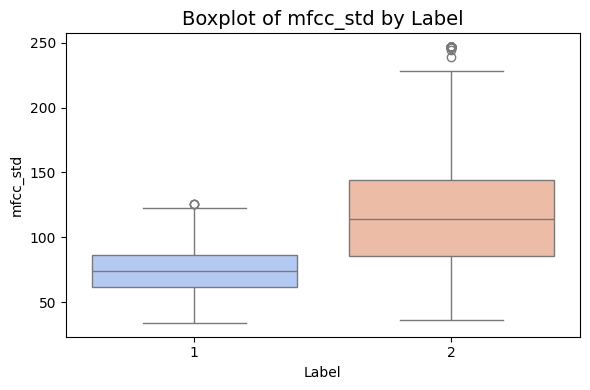

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


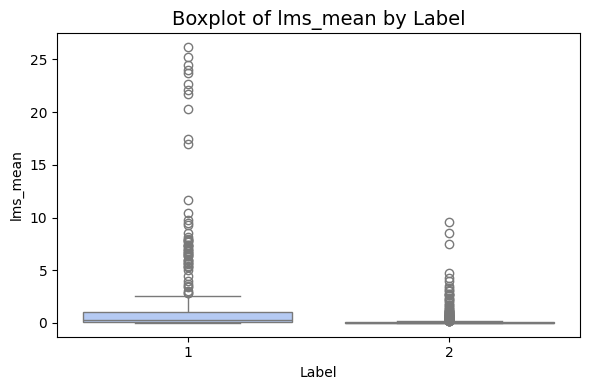

C:\Users\Lulay\AppData\Local\Temp\ipykernel_19732\2418880476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")


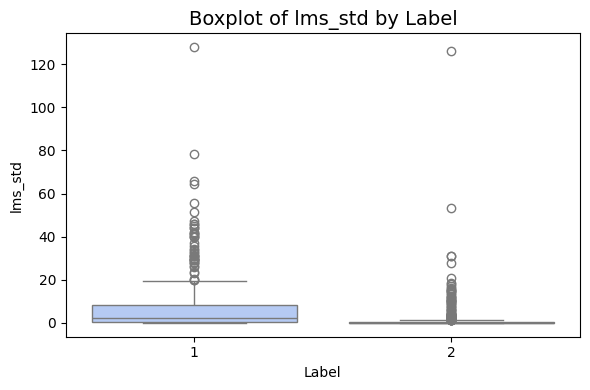

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(dataset_normalized)
features = df.columns.drop("Label")

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="Label", y=feature, palette="coolwarm")
    plt.title(f"Boxplot of {feature} by Label", fontsize=14)
    plt.xlabel("Label")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


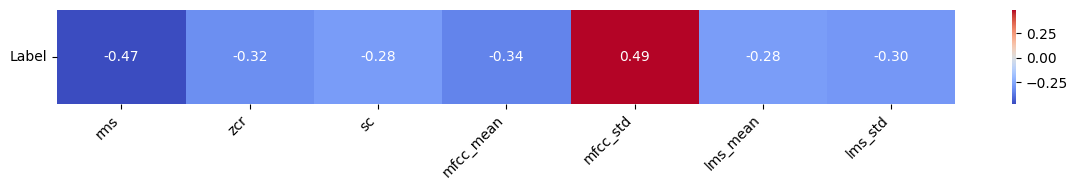

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(dataset_normalized)
correlation_matrix = df.corr(numeric_only=True)
label_corr = correlation_matrix.loc[["Label"]].drop(columns=["Label"])

plt.figure(figsize=(12, 2))
sns.heatmap(label_corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
